<font color = 'orange'>

# Random Forest Regression

</font>

* predicting Hokkaido's temperature in H2 2023 so I can be better prepared for an upcoming vacation
* temperature readings from Japan weather stations from Jan 2017 - Mar 2023
* units are in the metric system  |  Temperatures are in Celsius

In [1]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

<br><br>

## Import and clean dataset

In [2]:
# import dataset
weather_raw = pd.read_csv("dataset/japan_weather_historical.csv")
weather_raw.head()

,STATION,NAME,DATE,TAVG,TMAX,TMIN
0,JA000047409,"ABASHIRI, JA",12/1/2016,5.0,8.2,-4.3
1,JA000047409,"ABASHIRI, JA",12/2/2016,0.3,4.2,NaN
2,JA000047409,"ABASHIRI, JA",12/3/2016,3.0,4.9,-1.7
3,JA000047409,"ABASHIRI, JA",12/4/2016,8.7,11.6,1.6
4,JA000047409,"ABASHIRI, JA",12/5/2016,1.1,4.9,NaN


In [3]:
# retrieve the shape of the dataset
weather_raw.shape

(294551, 6)

In [4]:
# pull up a summary of the dataset
weather_raw.describe()

,TAVG,TMAX,TMIN
count,294551.000000,222175.000000,153993.000000
mean,14.595772,19.143391,10.297125
std,9.162445,9.346593,9.703712
min,-16.200000,-13.600000,-25.700000
25%,7.400000,12.200000,2.400000
50%,15.200000,19.900000,10.400000
75%,22.100000,26.600000,18.500000
max,34.800000,41.100000,30.300000


In [5]:
# checking data types
weather_raw.dtypes

STATION     object
NAME        object
DATE        object
TAVG       float64
TMAX       float64
TMIN       float64
dtype: object

In [6]:
# checking for null values
weather_raw.isnull().sum()

STATION         0
NAME            0
DATE            0
TAVG            0
TMAX        72376
TMIN       140558
dtype: int64

In [7]:
# changing datatype and switching column names to lower case
weather_raw.columns = map(str.lower, weather_raw.columns)
weather_raw["date"] = pd.to_datetime(weather_raw["date"])

# interpolate missing values
weather_raw = weather_raw.interpolate()
weather_raw.isnull().sum()

station    0
name       0
date       0
tavg       0
tmax       0
tmin       0
dtype: int64

In [8]:
# list of weather stations in Hokkaido
hokkaido_stations = ['ABASHIRI, JA', 'ASAHIKAWA, JA', 'ESASHI, JA', 'HABORO, JA', 'HAKODATE, JA', 'HIROO, JA', 'IWAMIZAWA, JA', 'KITAMIESASHI, JA', 'KUSHIRO, JA', 'KUTCHAN, JA', 'MOMBETSU, JA', 'MURORAN, JA', 'NEMURO, JA', 'OBIHIRO, JA', 'OTARU, JA', 'OMU, JA', 'RUMOI, JA', 'SAPPORO, JA', 'SUTTSU, JA', 'TOMAKOMAI, JA', 'URAKAWA, JA', 'WAKKANAI, JA']

# filtering for weather stations that are in Hokkaido
weather_h = weather_raw.loc[weather_raw['name'].isin(hokkaido_stations)]
weather_h = weather_h.sort_values(['name', 'date'], ascending = [True, True])

weather_h.describe()

,date,tavg,tmax,tmin
count,43449,43449.000000,43449.000000,43449.000000
mean,2020-01-27 00:38:32.670027264,8.049633,11.919541,3.686719
min,2016-12-01 00:00:00,-16.200000,-13.600000,-25.700000
25%,2018-06-26 00:00:00,-0.100000,3.600000,-4.100000
50%,2020-01-20 00:00:00,8.200000,12.100000,3.300000
75%,2021-09-01 00:00:00,16.200000,19.900000,12.000000
max,2023-03-31 00:00:00,30.800000,38.800000,25.100000
std,NaN,9.377317,9.551505,9.593213


<br><br>

## Exploring the dataset

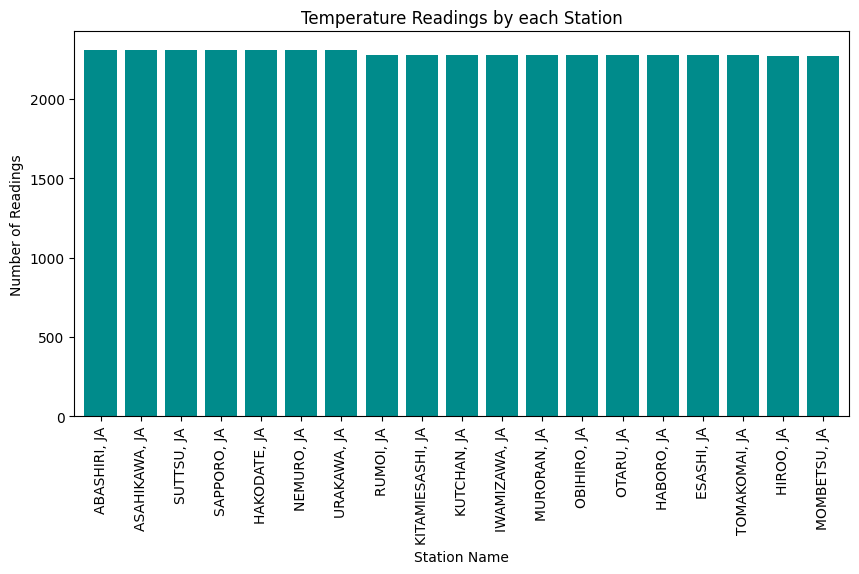

In [27]:
# plotting a bar chart to look at the distribution of temperature readings across the stations
weather_h['name'].value_counts().plot(
    kind='bar',
    color='darkcyan',
    width=0.8,
    figsize=(10, 5),
    xlabel='Station Name',
    ylabel='Number of Readings',
    title='Temperature Readings by each Station'
);

* dataset does not appear to underrepresent any particular weather stations in terms of no. of temperature readings

<br>

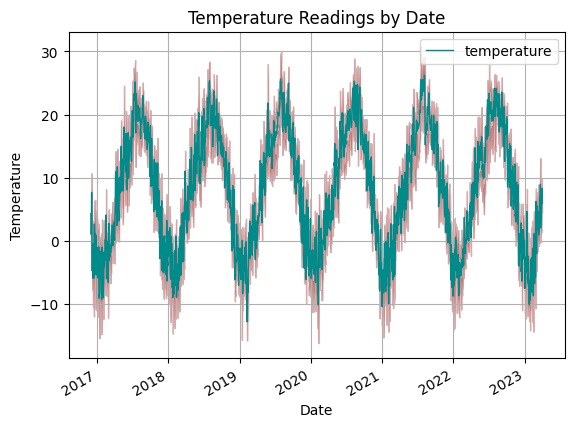

In [10]:
# plotting a line chart of the mean temperatures against against date, with a fill between min and max temperatures
line = weather_h.groupby(['date'], as_index=False).agg(
    min=pd.NamedAgg(column='tavg', aggfunc='min'),
    max=pd.NamedAgg(column='tavg', aggfunc='max'),
    mean=pd.NamedAgg(column='tavg', aggfunc=np.mean)
)
line.reset_index(inplace=True)

axis = line.plot(
    x='date',
    y='mean',
    grid=True,
    color='darkcyan',
    lw=1,
    label='temperature',
    xlabel='Date',
    ylabel='Temperature',
    title='Temperature Readings by Date'
)

axis.fill_between(
    x='date',
    y1='min',
    y2='max',
    data=line,
    color='maroon',
    alpha=0.3
)

plt.show()

* no clear anomalies in the dataset
* the chart shows a distinct and uniform seasonality
* account for this trait by passing historical temperature values as features through the model

<br>

<br><br>

## Prepare data for machine learning model

In [11]:
# splitting date into year, month and date
weather_h['day'] = weather_h['date'].dt.day
weather_h['month'] = weather_h['date'].dt.month
weather_h['year'] = weather_h['date'].dt.year

weather_h = weather_h[['name', 'year', 'month', 'day', 'date', 'tavg','tmax', 'tmin']]
weather_ht = weather_h.loc[weather_h['date'] >= '2017-01-01']

# aggregate the mean temperature across all stations in Hokkaido as a representation of Hokkaido's temperature
weather_ht = weather_ht.groupby(['year', 'month', 'day'], as_index=False).agg(
    year=('year', 'min'),
    month=('month', 'min'),
    day=('day', 'min'),
    date=('date', 'min'),
    tavg=('tavg', 'mean'),
    tmax=('tmax', 'mean'),
    tmin=('tmin', 'mean'))

weather_ht.head()

,year,month,day,date,tavg,tmax,tmin
0,2017,1,1,2017-01-01,-1.036842,0.655263,-5.868421
1,2017,1,2,2017-01-02,-1.073684,2.184211,-5.470877
2,2017,1,3,2017-01-03,-2.200000,0.857895,-5.962807
3,2017,1,4,2017-01-04,-2.584211,0.078947,-6.748596
4,2017,1,5,2017-01-05,-5.842105,-2.373684,-8.179123


In [12]:
# self merge to get the temperature from exactly 1 year, 2 years and 3 years prior and the historical average
weather_ht = pd.merge(pd.merge(weather_ht, weather_ht[['year', 'month', 'day', 'tavg', 'tmax', 'tmin']], on=['month', 'day']), weather_ht[['year', 'month', 'day', 'tavg', 'tmax', 'tmin']], on=['month', 'day'])
weather_ht = weather_ht.rename(columns={'year_x': 'year1', 'tavg_x': 'tavg1', 'tmax_x': 'tmax1', 'tmin_x': 'tmin1', 'year_y': 'year2', 'tavg_y': 'tavg2', 'tmax_y': 'tmax2', 'tmin_y': 'tmin2'})
weather_ht = pd.merge(weather_ht, weather_ht, on=['month', 'day'])
weather_ht = weather_ht.rename(columns={'year_x': 'year', 'year1_x': 'year1', 'year2_x': 'year2', 'year_y': 'year3', 'tavg_x': 'tavg', 'tavg1_x': 'tavg1', 'tavg2_x': 'tavg2', 'tavg_y': 'tavg3',  'tmax_x': 'tmax', 'tmax1_x': 'tmax1', 'tmax2_x': 'tmax2', 'tmax_y': 'tmax3',  'tmin_x': 'tmin', 'tmin1_x': 'tmin1', 'tmin2_x': 'tmin2', 'tmin_y': 'tmin3'})

weather_ht = weather_ht.loc[(weather_ht['year'] - weather_ht['year1'] == 1) & (weather_ht['year'] - weather_ht['year2'] == 2) & (weather_ht['year'] - weather_ht['year3'] == 3)].drop_duplicates(subset=['year', 'month', 'day'], keep='first')
weather_ht = weather_ht.drop(['year1', 'year2', 'year3'], axis=1)

weather_ht['tavgr'] = (weather_ht['tavg1'] + weather_ht['tavg2'] + weather_ht['tavg3']) / 3
weather_ht['tmaxr'] = (weather_ht['tmax1'] + weather_ht['tmax2'] + weather_ht['tmax3']) / 3
weather_ht['tminr'] = (weather_ht['tmin1'] + weather_ht['tmin2'] + weather_ht['tmin3']) / 3

weather_ht = weather_ht[['year', 'month', 'day', 'tavg', 'tavg1', 'tavg2', 'tavg3', 'tavgr', 'tmax', 'tmax1', 'tmax2', 'tmax3', 'tmaxr', 'tmin', 'tmin1', 'tmin2', 'tmin3', 'tminr']]
weather_ht = weather_ht.sort_values(['year', 'month', 'day'], ascending=[True, True, True]).reset_index(drop=True)

weather_ht.head()

,year,month,day,tavg,tavg1,tavg2,tavg3,tavgr,tmax,tmax1,tmax2,tmax3,tmaxr,tmin,tmin1,tmin2,tmin3,tminr
0,2020,1,1,-4.805263,-2.973684,1.526316,-1.036842,-0.828070,-2.272982,-0.531579,3.010526,0.655263,1.044737,-7.542105,-6.947995,-2.377193,-5.868421,-5.064536
1,2020,1,2,-3.094737,-4.942105,-0.452632,-1.073684,-2.156140,-1.352281,-1.573684,2.694737,2.184211,1.101754,-6.131053,-7.935652,-3.639474,-5.470877,-5.682001
2,2020,1,3,-4.000000,-3.268421,-1.605263,-2.200000,-2.357895,-0.294737,-0.805263,1.426316,0.857895,0.492982,-7.377895,-8.652256,-5.093860,-5.962807,-6.569641
3,2020,1,4,-5.984211,-1.147368,-2.415789,-2.584211,-2.049123,-2.573246,0.963158,-0.149123,0.078947,0.297661,-8.593158,-6.281316,-5.072368,-6.748596,-6.034094
4,2020,1,5,-3.978947,-4.100000,-1.342105,-5.842105,-3.761404,-1.185088,-0.800000,0.254386,-2.373684,-0.973099,-9.200526,-7.007368,-4.528947,-8.179123,-6.571813


<br><br>

## Train and test model

In [13]:
# split data into features and labels
h_out = weather_ht['tavg'] 
h_in = weather_ht[['year', 'month', 'day', 'tavg1', 'tavg2', 'tavg3', 'tavgr','tmax1', 'tmax2', 'tmax3', 'tmaxr', 'tmin1', 'tmin2', 'tmin3', 'tminr']]
h_list = list(h_in.columns)

In [14]:
# train test split 3 : 1
train_in, test_in, train_out, test_out = train_test_split(h_in, h_out, train_size=0.75, random_state=42)

print(train_in.shape, test_in.shape, train_out.shape, test_out.shape, sep='   .   ')

(882, 15)   .   (294, 15)   .   (882,)   .   (294,)


In [15]:
# we will be using historical average temperature as a baseline
baseline_p = test_in['tavgr']
baseline_err = abs(baseline_p - test_out)
baseline_mean_err = np.mean(baseline_err)

print('Baseline mean error to beat = ', round(baseline_mean_err, 2), ' degree celcius')

Baseline mean error to beat =  2.5  degree celcius


In [16]:
# setting up the model and training it
r = RandomForestRegressor (n_estimators=1000, random_state=42)
r.fit(train_in, train_out);

In [17]:
# running the test data
p = r.predict(test_in)
err = abs(p - test_out)
mae = np.mean(err)
acc = 100 - np.mean(100 * (err/test_out))
beat = round(100 - (mae / baseline_mean_err) * 100, 2)

print('Model has a baseline error of ', round(mae, 2), ', which is ', beat, '% better. ', 'It has an accuracy of ', round(acc, 2), '%', sep='')

Model has a baseline error of 2.07, which is 17.14% better. It has an accuracy of 93.61%


<br><br>

## Evaluate the model

In [18]:
# finding out the importance of the features
impt = r.feature_importances_
in_impt = pd.DataFrame(impt, index=[h_list], columns=['importance'])
in_impt['importance'] = in_impt['importance'].round(decimals=2)
in_impt = in_impt.sort_values(['importance'], ascending=False)

in_impt

,importance
tminr,0.63
tmaxr,0.20
tavgr,0.05
tmin2,0.03
tmin1,0.02
month,0.01
day,0.01
tavg1,0.01
tmax1,0.01
tmax2,0.01


* the historical minimum and historical maximum temperatures are the most important features when predicting future temperatures for this model

<br>

In [19]:
# recombine the year, month and day into date
pd.options.mode.chained_assignment = None
h_in['date'] = pd.to_datetime(h_in['year'].astype(str) + '-' + h_in['month'].astype(str) + '-' + h_in['day'].astype(str))
test_in['date'] = pd.to_datetime(test_in['year'].astype(str) + '-' + test_in['month'].astype(str) + '-' + test_in['day'].astype(str))
pd.options.mode.chained_assignment = 'warn'

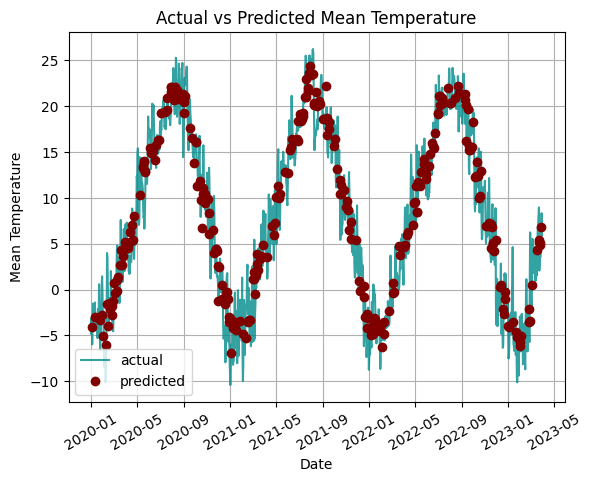

In [20]:
# plot the predicted values on top of actual values to visually compare how close they are
plt.plot(
    h_in['date'],
    h_out,
    label='actual',
    color='darkcyan',
    alpha=0.8
)

plt.plot(
    test_in['date'],
    p,
    'o',
    label='predicted',
    color='maroon'
)

plt.xticks(rotation = 30)
plt.legend()
plt.xlabel('Date');
plt.ylabel('Mean Temperature');
plt.title('Actual vs Predicted Mean Temperature');
plt.grid(True)

* no anomalies spotted visually
* the model seems to provide a decent prediction for temperatures within 1 year from the dataset provided

<br>

<br><br>

## Put the model into action

In [21]:
# importing H2 2023 dataset with only features
h2_2023 = pd.read_csv("dataset/japan_weather_future.csv")
h2_2023.head()

,year,month,day,tavg1,tavg2,tavg3,tavgr,tmax1,tmax2,tmax3,tmaxr,tmin1,tmin2,tmin3,tminr
0,2023,4,1,0.521053,4.800000,7.147368,4.156140,6.664411,11.089839,10.047801,9.267350,0.713947,0.998246,-3.691228,-0.659678
1,2023,4,2,4.663158,6.778947,4.442105,5.294737,8.633943,11.346640,8.963147,9.647910,-0.068421,0.728070,-3.440351,-0.926901
2,2023,4,3,5.584211,8.263158,6.147368,6.664912,10.190318,12.145546,10.473230,10.936364,1.887281,0.231579,-3.480702,-0.453947
3,2023,4,4,6.547368,4.273684,7.294737,6.038596,11.544938,8.928662,11.679770,10.717790,1.008333,0.726316,-2.778947,-0.348099
4,2023,4,5,8.957895,3.684211,3.352632,5.331579,12.589032,9.945989,7.844206,10.126409,0.129386,0.330702,-1.035526,-0.191813


In [22]:
# run the model
p2 = r.predict(h2_2023)

In [23]:
# combining year, month and day into date
h2_2023p = h2_2023
h2_2023p['tavgp'] = pd.DataFrame(p2)
h2_2023p['date'] = pd.to_datetime(h2_2023['year'].astype(str) + '-' + h2_2023['month'].astype(str) + '-' + h2_2023['day'].astype(str))

# creating min and max ranges of predicted temperature based on model's mean absolute error
h2_2023p['tavgp_low'] = h2_2023p['tavgp'] - mae
h2_2023p['tavgp_high'] = h2_2023p['tavgp'] + mae
h2_2023p = h2_2023p[['date', 'tavgp', 'tavgp_high', 'tavgp_low']]

testt = h2_2023p.loc[(h2_2023p['date'] >= '2023-10-19') & (h2_2023p['date'] <= '2023-11-05')]

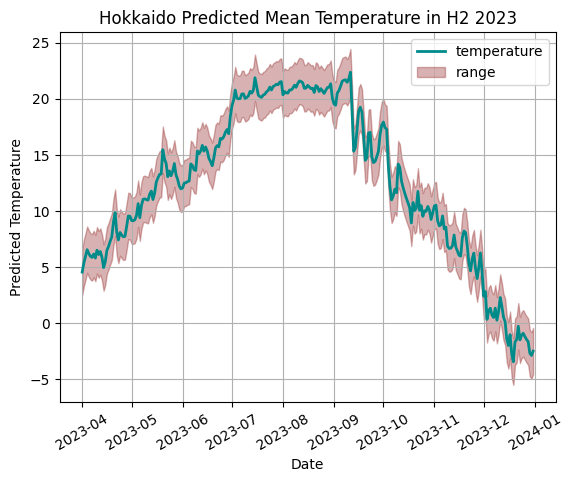

In [24]:
plt.plot(
    h2_2023p['date'],
    h2_2023p['tavgp'],
    label='temperature',
    color='darkcyan',
    lw=2
)

plt.fill_between(
    x=h2_2023p['date'],
    y1=h2_2023p['tavgp_low'],
    y2=h2_2023p['tavgp_high'],
    label='range',
    color='maroon',
    alpha=0.3
)

plt.xticks(rotation = 30); 
plt.legend()
plt.xlabel('Date');
plt.ylabel('Predicted Temperature');
plt.title('Hokkaido Predicted Mean Temperature in H2 2023');
plt.grid(True)

<br><br><br><br>

# Acknowledgements
* data courtesy of NOAA